In [1]:
# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras
import glob, natsort

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.3.0


In [2]:
from keras.models import load_model

model = load_model('mnist_test_model.h5')
model.summary()  # 기억을 되살리기 위해서 모델 구조를 출력합니다

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 28)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 28)        7084      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 28)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 28)                0         
_________________________________________________________________
dense (Dense)                (None, 14)                406       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [9]:
img_path = './mnist_png/train/7/1001.png'

# 이미지를 4D 텐서로 변경합니다
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(28, 28))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# 모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용합니다
img_tensor /= 255.

# 이미지 텐서의 크기는 (1, 150, 150, 3)입니다
print(img_tensor.shape)

(1, 28, 28, 3)


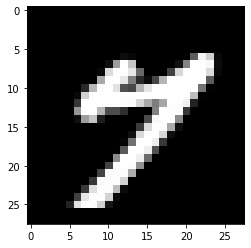

In [10]:
plt.imshow(img_tensor[0])
plt.show()

## 1. model의 층에서 어떻게 나오는지를 보기

In [11]:
from keras import models

# 상위 8개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:8]]

# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [12]:
# 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트를 반환합니다:
activations = activation_model.predict(img_tensor)

In [13]:

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 26, 26, 28)


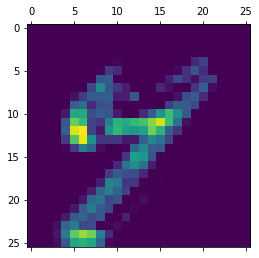

In [14]:
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.show()

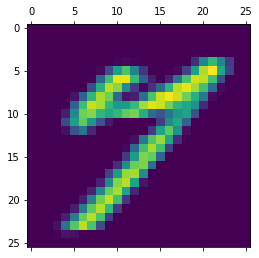

In [15]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

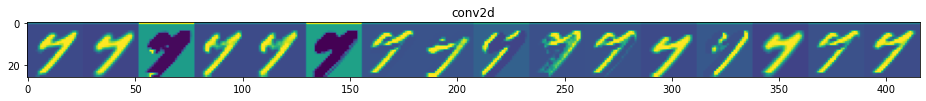

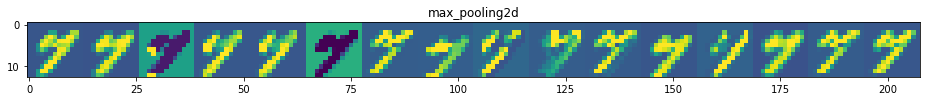

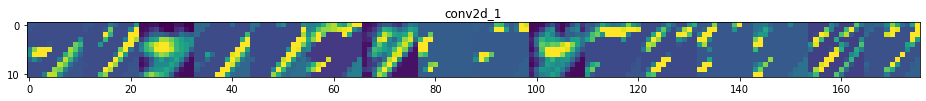

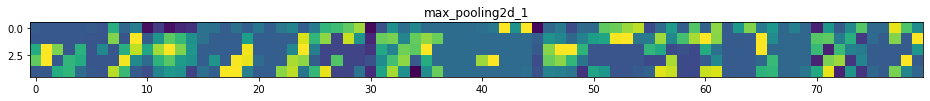

In [25]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

## 2. 컨브넷 필터 시각화

In [36]:
from keras import backend as K
import tensorflow as tf

filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, filter_index])

In [37]:
layer_output

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(None, 28) dtype=float32>

In [38]:
loss

<tf.Tensor 'Mean_2:0' shape=() dtype=float32>

In [39]:
# gradients 함수가 반환하는 텐서 리스트(여기에서는 크기가 1인 리스트)에서 첫 번째 텐서를 추출합니다
#grads = K.gradients(loss, model.input)[0]
grads = tf.GradientTape(loss, model.input)[0]

# 0 나눗셈을 방지하기 위해 1e–5을 더합니다
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)



iterate = K.function([model.input], [loss, grads])

# 테스트:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 28, 28, 3))])


# 잡음이 섞인 회색 이미지로 시작합니다
input_img_data = np.random.random((1, 28, 28, 3)) * 20 + 128.

# 업데이트할 그래디언트의 크기
step = 1.
for i in range(40):   # 경사 상승법을 40회 실행합니다
    # 손실과 그래디언트를 계산합니다
    loss_value, grads_value = iterate([input_img_data])
    # 손실을 최대화하는 방향으로 입력 이미지를 수정합니다
    input_img_data += grads_value * step

TypeError: 'GradientTape' object is not subscriptable